# Land Cover Classification using Deep Learning Techniques and EuroSAT

### CS294-82
### Simona Aksman

## Mounting google drive for dataset access and saving models

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Libraries

In [2]:
import os
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from tqdm.notebook import tqdm
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn import model_selection

import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import transforms
from torchvision.utils import make_grid
import torch.nn.functional as F
import tensorflow as tf
import tensorflow_datasets as tfds

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to ./eurosat/rgb/2.0.0.incompleteKQ1HKQ/eurosat-train.tfrecord


  0%|          | 0/27000 [00:00<?, ? examples/s]

Dataset eurosat downloaded and prepared to ./eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


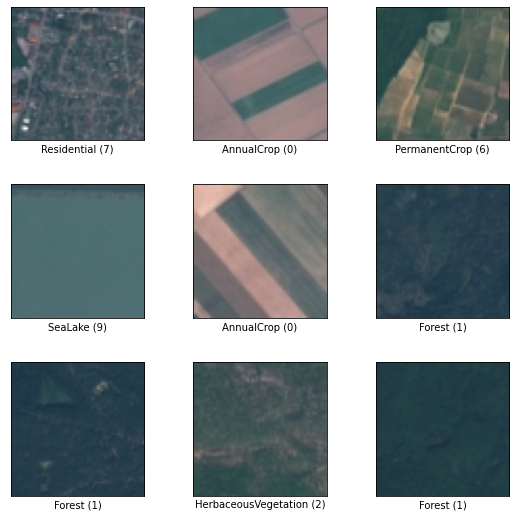

In [3]:
DATA_DIR = '.'

ds, ds_info = tfds.load('eurosat/rgb',
                        with_info=True,
                        split='train',
                        data_dir=DATA_DIR)

tfds.show_examples(ds, ds_info);

In [ ]:
ds_df = tfds.as_dataframe(ds, ds_info)

In [ ]:
ds_df.head()

filename  ... label
0    b'Residential_397.jpg'  ...     7
1     b'AnnualCrop_825.jpg'  ...     0
2  b'PermanentCrop_818.jpg'  ...     6
3         b'SeaLake_53.jpg'  ...     9
4     b'AnnualCrop_387.jpg'  ...     0

[5 rows x 3 columns]

## Config

In [ ]:
IDX_CLASS_LABELS = {
    0: 'AnnualCrop',
    1: 'Forest', 
    2: 'HerbaceousVegetation',
    3: 'Highway',
    4: 'Industrial',
    5: 'Pasture',
    6: 'PermanentCrop',
    7: 'Residential',
    8: 'River',
    9: 'SeaLake'
}
CLASSES = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture','PermanentCrop','Residential','River', 'SeaLake']
CLASS_IDX_LABELS = dict()
for key, val in IDX_CLASS_LABELS.items():
  CLASS_IDX_LABELS[val] = key

NUM_CLASSES = len(IDX_CLASS_LABELS.items())
torch.manual_seed(10)
VALID_SIZE = 0.2


## Utils

In [ ]:
## Give idx of each class name
def encode_label(label):
    idx = CLASS_IDX_LABELS[label] 
    return idx

## Take in idx and return the class name
def decode_target(target, text_labels=True):
    result = []
    if text_labels:
        return IDX_CLASS_LABELS[target]
    else:
        return target

## Show batches of images
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

In [ ]:
## Example for decoding and encoding
print(encode_label('Forest'), decode_target(2))
print(decode_target(2, text_labels=True))

1 HerbaceousVegetation
HerbaceousVegetation


## Processing data to train and test


In [ ]:
DATA_DF = ds_df
DATA_DF['filename'].str.decode("utf-8")

0                  Residential_397.jpg
1                   AnnualCrop_825.jpg
2                PermanentCrop_818.jpg
3                       SeaLake_53.jpg
4                   AnnualCrop_387.jpg
                     ...              
26995            PermanentCrop_903.jpg
26996                   River_1297.jpg
26997                   Forest_950.jpg
26998                  Forest_2654.jpg
26999    HerbaceousVegetation_2624.jpg
Name: filename, Length: 27000, dtype: object

In [ ]:
TRAIN_DF, VALID_DF, TEST_DF = np.split(DATA_DF.sample(frac=1, random_state=42), [int(.8*len(DATA_DF)), int(.9*len(DATA_DF))])
TRAIN_DF.reset_index(inplace = True) 
VALID_DF.reset_index(inplace = True) 
TEST_DF.reset_index(inplace = True) 

In [ ]:
TRAIN_DF.shape

(21600, 4)

In [ ]:
VALID_DF.shape

(2700, 4)

In [ ]:
TEST_DF.shape

(2700, 4)

## Estimating noise in data

In [ ]:
from skimage.restoration import estimate_sigma

TRAIN_DF['noise'] = TRAIN_DF['image'].apply(lambda x: estimate_sigma(x, multichannel=True, average_sigmas=True))
TRAIN_DF['label_name'] = TRAIN_DF['label'].apply(lambda x: decode_target(x))

In [ ]:
mean_noise_by_class = TRAIN_DF.groupby('label_name', as_index=False)['noise'].mean()
mean_noise_by_class

label_name     noise
0            AnnualCrop  1.284461
1                Forest  1.248610
2  HerbaceousVegetation  2.084568
3               Highway  2.176731
4            Industrial  4.362815
5               Pasture  1.228913
6         PermanentCrop  2.311389
7           Residential  4.783507
8                 River  1.480761
9               SeaLake  0.812509

In [ ]:
std_noise_by_class = TRAIN_DF.groupby('label_name', as_index=False)['noise'].std()
std_noise_by_class

label_name     noise
0            AnnualCrop  0.333829
1                Forest  0.230400
2  HerbaceousVegetation  1.000515
3               Highway  0.938687
4            Industrial  1.274609
5               Pasture  0.189788
6         PermanentCrop  0.887304
7           Residential  1.737094
8                 River  0.440732
9               SeaLake  0.072201

In [ ]:
mean_noise_by_class['var_mean_ratio'] = std_noise_by_class['noise'] / mean_noise_by_class['noise']
mean_noise_by_class['snr'] = mean_noise_by_class['var_mean_ratio'].apply(lambda x: 20 * math.log10(x))
mean_noise_by_class

label_name     noise  var_mean_ratio        snr
0            AnnualCrop  1.284461        0.259898 -11.703936
1                Forest  1.248610        0.184525 -14.678892
2  HerbaceousVegetation  2.084568        0.479963  -6.375849
3               Highway  2.176731        0.431237  -7.305676
4            Industrial  4.362815        0.292153 -10.687796
5               Pasture  1.228913        0.154436 -16.225036
6         PermanentCrop  2.311389        0.383883  -8.316015
7           Residential  4.783507        0.363142  -8.798462
8                 River  1.480761        0.297639 -10.526201
9               SeaLake  0.812509        0.088862 -21.025684

In [ ]:
mean_noise_by_class[["label_name", "snr"]].sort_values(by=['snr']).rename(columns={"label_name": 'Class', 'snr': 'Resilience to noise (dB)'})

Class  Resilience to noise (dB)
9               SeaLake                -21.025684
5               Pasture                -16.225036
1                Forest                -14.678892
0            AnnualCrop                -11.703936
4            Industrial                -10.687796
8                 River                -10.526201
7           Residential                 -8.798462
6         PermanentCrop                 -8.316015
3               Highway                 -7.305676
2  HerbaceousVegetation                 -6.375849

## Creating Dataset and Dataloaders

Now we will Create custom dataset by extending pytorch Dataset class. We also add provision for adding transformers for data augmentation.

In [ ]:
import torchvision.transforms as transforms

class EuroSAT(Dataset):
    def __init__(self, train_df, train_dir, transform=None):
        self.train_dir = train_dir
        self.train_df = train_df
        self.transform = transform
        
    def __len__(self):
        return len(self.train_df)
    
    def __getitem__(self, idx):
        row = self.train_df.loc[idx]
        img_id, label = row['filename'], decode_target(row['label'])
        img = transforms.ToPILImage()(row['image'])
        if self.transform:
            img = self.transform(img)
        return img, encode_label(label)

### Transformations and Datasets

In [ ]:
## Dataset and transformations
data_transform = transforms.Compose([
                                transforms.Resize(size=(224, 224)),
                                transforms.ToTensor(),
                                ])
train_ds = EuroSAT(TRAIN_DF, '.', data_transform)
valid_ds = EuroSAT(VALID_DF, '.', data_transform)
print(len(train_ds), len(valid_ds))

21600 2700


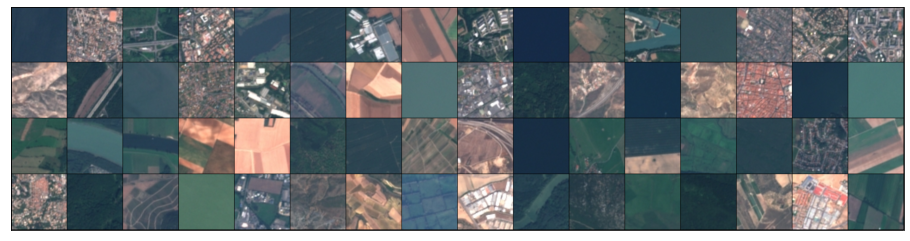

In [ ]:
## Data loaders and showing batch of data
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, shuffle=False, num_workers=2, pin_memory=True)
show_batch(train_dl)

## Model

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds==labels).item() / len(preds))

class MulticlassClassifierBase(nn.Module):
    
    def training_step(self, batch):
        img, label = batch
        out = self(img)
        loss = criterion(out, label)
        accu = accuracy(out, label)
        return accu ,loss
    def validation_step(self, batch):
        img, label = batch
        out = self(img)
        loss = criterion(out, label)
        accu = accuracy(out, label)
        return {"val_loss": loss.detach(), "val_acc": accu}
    
    def validation_epoch_ends(self, outputs):
        batch_loss = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {"val_loss":epoch_loss.item(), "val_acc":epoch_acc.item()}
    def epoch_end(self, epoch, result):
        print("Epoch [{}],train_accu: {:.4f}, learning_rate: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch,result['train_accu'], result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class GoogleNet(MulticlassClassifierBase):
    def __init__(self):
        super().__init__()
        self.network = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
        n_inputs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
                              nn.Linear(n_inputs, 256),
                              nn.ReLU(),
                              nn.Dropout(0.5),
                              nn.Linear(256, NUM_CLASSES),
                              nn.LogSoftmax(dim=1)
                                )
    def forward(self, xb):
        return self.network(xb)
    
    def freeze(self):
        for param in self.network.parameters():
            param.require_grad=False
        for param in self.network.fc.parameters():
            param.require_grad=True
    def unfreeze(self):
        for param in self.network.parameters():
            param.require_grad=True

In [ ]:
model = GoogleNet()

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [ ]:
## Running through the data loader => Model => Output
def try_batch(dl):
  for images, labels in dl:  
    print(images.shape)
    out = model(images)
    print(out.shape)
    print(out[0])
    break

try_batch(train_dl)

torch.Size([64, 3, 224, 224])
torch.Size([64, 10])
tensor([-2.2372, -2.2670, -2.3435, -2.3853, -2.4287, -2.2847, -2.2502, -2.2746,
        -2.1931, -2.3879], grad_fn=<SelectBackward0>)


## Training and Evaluating

In [ ]:
@torch.no_grad()
def evaluate(model, valid_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in valid_loader]
    return model.validation_epoch_ends(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def fit(epochs, max_lr,  model, train_loader, valid_loader, weight_decay=0,\
                grad_clip=None,opt_func=torch.optim.SGD, max_epochs_stop=3):
  
    history = []
    valid_loss_min = np.Inf
    valid_acc_max = 0
    model_file_name = 'lulc.pth'
    model_file_name2 = 'lulc_max_acc.pth'
    epochs_no_improve =  0
    optimizer = opt_func(model.parameters(), lr=max_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.00001)
                         
    for epoch in range(epochs):
        model.train()
        train_loss = []
        train_accu = []
        lrs = []
        for batch in tqdm(train_loader):
            
            accu, loss = model.training_step(batch)
            train_loss.append(loss)
            train_accu.append(accu)
            loss.backward()
            ## Gradient Clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            
            
            
        result = evaluate(model, valid_loader)
        scheduler.step(result['val_loss'])
        ########### Early Stopping ##############                                         
        valid_loss = result['val_loss']
        valid_acc = result['val_acc']
        if valid_acc > valid_acc_max:
            torch.save(model.state_dict(), model_file_name2)
            valid_acc_max = valid_acc
        if valid_loss<valid_loss_min:
            torch.save(model.state_dict(), model_file_name)
            valid_loss_min = valid_loss                                  
            epochs_no_improve = 0          
        else:
            epochs_no_improve += 1
            if epochs_no_improve > max_epochs_stop:
                result["train_loss"] = torch.stack(train_loss).mean().item()
                result["train_accu"] = torch.stack(train_accu).mean().item()
                result["lrs"] = lrs
                model.epoch_end(epoch, result)
                history.append(result)
                print("Early Stopping............................")
                return history                                
                                                 
        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["train_accu"] = torch.stack(train_accu).mean().item()
        result["lrs"] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    print("VAL LOSS MIN {}".format(valid_loss_min))
    print("VAL ACC MAX {}".format(valid_acc_max))
    return history

## Initializing Device also Loading Data and Model to device¶


In [ ]:
def get_device():
    print(torch.cuda.is_available())
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

In [ ]:
device = get_device()
## Loading data to devide
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
## Loading model to device
model = to_device(GoogleNet(), device)
## lets try passing a batch to model again
try_batch(train_dl)

True


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


torch.Size([64, 3, 224, 224])
torch.Size([64, 10])
tensor([-2.3546, -2.3578, -2.3292, -2.1694, -2.2926, -2.4798, -2.1308, -2.2700,
        -2.2959, -2.3932], device='cuda:0', grad_fn=<SelectBackward0>)


In [ ]:
torch.cuda.empty_cache()

## Training at original capacity

In [ ]:
## Hyper Parameters
max_epochs_stop = 15
max_lr = 1e-4
grad_clip = 0.1
weight_decay = 1e-3
batch_size = 64
criterion = nn.CrossEntropyLoss()
epochs = 15
opt_func = torch.optim.Adam
## Evaluating with non-trained model
evaluate(model, valid_dl)

{'val_acc': 0.0846657007932663, 'val_loss': 2.307539701461792}

In [ ]:
## Freezing except last layer
model.freeze()
## Training
history = fit(epochs, max_lr, model, train_dl, valid_dl, weight_decay, grad_clip, opt_func, max_epochs_stop)

  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [0],train_accu: 0.8817, learning_rate: 0.0001, train_loss: 0.4535, val_loss: 0.1163, val_acc: 0.9637


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [1],train_accu: 0.9718, learning_rate: 0.0001, train_loss: 0.0987, val_loss: 0.0749, val_acc: 0.9753


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [2],train_accu: 0.9802, learning_rate: 0.0001, train_loss: 0.0678, val_loss: 0.0830, val_acc: 0.9749


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [3],train_accu: 0.9847, learning_rate: 0.0001, train_loss: 0.0494, val_loss: 0.0704, val_acc: 0.9786


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [4],train_accu: 0.9865, learning_rate: 0.0001, train_loss: 0.0452, val_loss: 0.0828, val_acc: 0.9749


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [5],train_accu: 0.9894, learning_rate: 0.0001, train_loss: 0.0354, val_loss: 0.0825, val_acc: 0.9775


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [6],train_accu: 0.9902, learning_rate: 0.0001, train_loss: 0.0345, val_loss: 0.0764, val_acc: 0.9800


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [7],train_accu: 0.9926, learning_rate: 0.0000, train_loss: 0.0266, val_loss: 0.0712, val_acc: 0.9789


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [8],train_accu: 0.9922, learning_rate: 0.0000, train_loss: 0.0252, val_loss: 0.0715, val_acc: 0.9804


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [9],train_accu: 0.9928, learning_rate: 0.0000, train_loss: 0.0244, val_loss: 0.0699, val_acc: 0.9797


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [10],train_accu: 0.9918, learning_rate: 0.0000, train_loss: 0.0257, val_loss: 0.0699, val_acc: 0.9793


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [11],train_accu: 0.9920, learning_rate: 0.0000, train_loss: 0.0254, val_loss: 0.0733, val_acc: 0.9786


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [12],train_accu: 0.9923, learning_rate: 0.0000, train_loss: 0.0257, val_loss: 0.0779, val_acc: 0.9767


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [13],train_accu: 0.9931, learning_rate: 0.0000, train_loss: 0.0242, val_loss: 0.0705, val_acc: 0.9793


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [14],train_accu: 0.9928, learning_rate: 0.0000, train_loss: 0.0247, val_loss: 0.0718, val_acc: 0.9782
VAL LOSS MIN 0.06986431777477264
VAL ACC MAX 0.9803779125213623


## Reports

### Training Reports

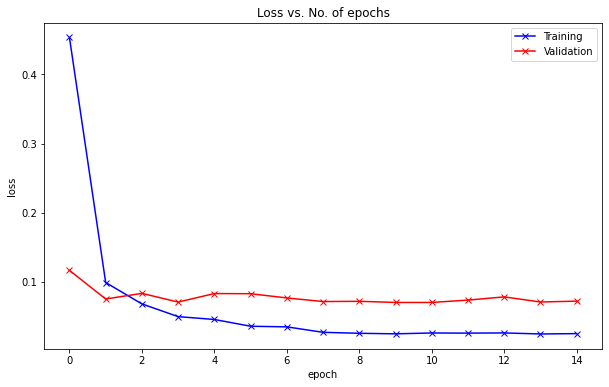

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
plot_losses(history)

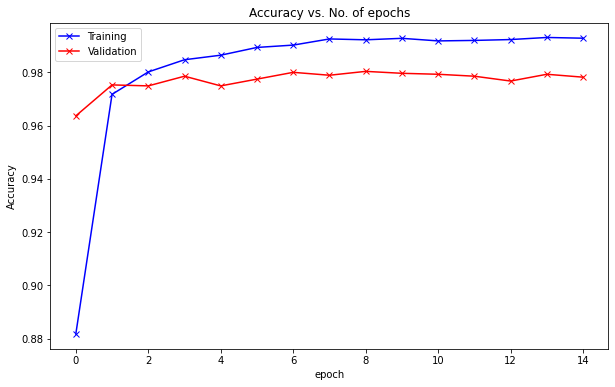

In [ ]:
def plot_accuracy(history):
        
    train_accu = [x.get('train_accu') for x in history]
    val_accu = [x['val_acc'] for x in history]
    plt.plot(train_accu, '-bx')
    plt.plot(val_accu, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');
plot_accuracy(history)

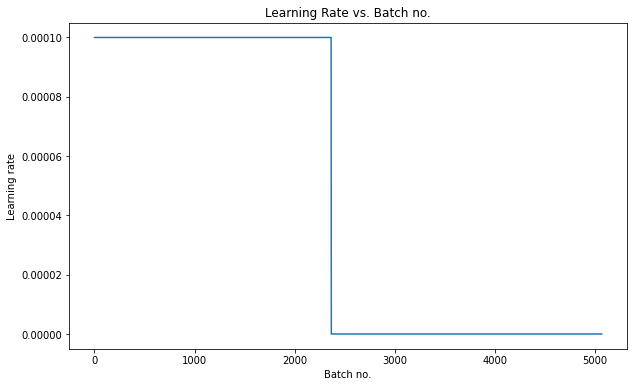

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
    
plot_lrs(history)

### Prediction Reports

In [ ]:
def show_sample(img, target=None):
    if target:
        print("Label" ,decode_target(int(target), text_labels=True))
    plt.imshow(img.permute(1, 2, 0))

### Predict Single Images
def predict_single(image):
    show_sample(image)
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    _, prediction = torch.max(preds.cpu().detach(), dim=1)
    return decode_target(int(prediction), text_labels=True)


'Industrial'

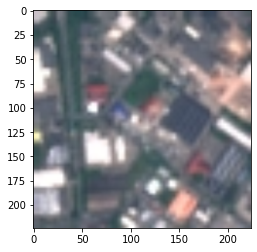

In [ ]:
predict_single(valid_ds[10][0])

'HerbaceousVegetation'

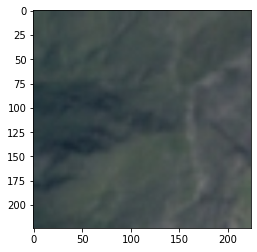

In [ ]:
predict_single(valid_ds[25][0])

'Residential'

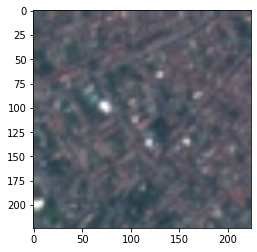

In [ ]:
predict_single(valid_ds[120][0])

## Evaluation on whole dataset and extract CNN layer per item

In [ ]:
batch_size = 1
@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_pred, labels = [], []
    for xb, label in tqdm(dl):
        probs = model(xb)
        _, pred = torch.max(probs.cpu().detach(), dim=1)
        batch_pred.append(pred.cpu().detach())     
        labels.append(label)   
    return [x for x in batch_pred], \
            [x for x in labels]

In [ ]:
## Accuracy Evaluation
def final_accuracy(predictions, labels):
  predictions = to_device(predictions, device)
  labels = to_device(labels, device)
  ## Total Accuracy
  total = 0
  for i in range(len(predictions)):
    if predictions[i] == labels[i]:
      total += 1
  acc = total/len(predictions)
  print(acc)

In [ ]:
# Save off CNN layer per image

def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

# Register hook
model.network.avgpool.register_forward_hook(get_features('avgpool'))

features = {}
batch_size = 1
@torch.no_grad()
def predict_extract_cnn_dl(dl, model):
    torch.cuda.empty_cache()
    batch_pred, batch_cnns, labels = [], [], []

    for xb, label in tqdm(dl):
        probs = model(xb)
        _, pred = torch.max(probs.cpu().detach(), dim=1)
        batch_pred.append(pred.cpu().detach())    
        batch_cnns.append(features['avgpool'].cpu().numpy())
        labels.append(label.cpu().numpy())   
    return [x for x in batch_pred], [x for x in batch_cnns], [x for x in labels]

In [ ]:
full_ds = EuroSAT(DATA_DF, '.', data_transform)
full_dl = DataLoader(full_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)
device = get_device()
## Loading data to device
full_dl = DeviceDataLoader(full_dl, device)


True


In [ ]:
predictions, cnns, labels = predict_extract_cnn_dl(full_dl, model)

  0%|          | 0/27000 [00:00<?, ?it/s]

In [ ]:
cnns_flattened = [x.flatten() for x in cnns]
cnns_df = pd.DataFrame({'googlenet_avgpool_layer': cnns_flattened, 'label': labels})

# Calculate data MEC

In [ ]:
def calculate_mec(data, labels):
	'''
	Calculate MEC needed for a classifier assuming weight
	equilibrium (no gradient descent). 
	Requires: data array of length n  which contains d-dim vectors 
	x, and a label column of length n.

	Parameters
  ----------
  data : array
    
  Returns
  -------
  mec : float

	'''
	assert len(data) == len(labels)

	# d = num dimensions in data
	d = data[0].shape[0]

	thresholds = 0
	table = []
	for i in range(len(data)):
	  # Sum up all data in the row and append the label
	  table.append([data[i].sum(), labels[i]])
	# Sort by sum in reverse order
	sortedtable = sorted(table, key=lambda x: x[0], reverse=True)

	# Iterate through sorted table and compute thresholds
	# by comparing class labels for each row and the prior row
	# Initialize with first class label in list
	class_label = sortedtable[0][1]
	for i in range(len(sortedtable)):
	  if not sortedtable[i][1] == class_label:
	    thresholds = thresholds + 1 
	    class_label = sortedtable[i][1]

	mec = math.log2(thresholds + 1) * d
	return mec

def get_sample(p, data, labels, seed):
	'''
	Return p percent of the data with corresponding labels.

	Parameters
	----------
	p : float in range [0, 1]
	data : array
	labels : array
    seed  : int

  Returns
  -------
  data, labels : array, array

	'''
	num_labels = len(labels)
	size = int(p * num_labels)

	np.random.seed(seed)
	np.random.shuffle(data)
	np.random.shuffle(labels)
	
	return data[:size], labels[:size] 


# Algorithm 2 
def calculate_capacity_progression(data, labels):
	'''
	Calculate capacity progression for the Equilibrium Machine Learner.
	Requires: data array of length n  which contains d-dim vectors 
	x, and a binary label column of length n.

	Parameters
  ----------
  data : array
  labels : array
    
  Returns
  -------
  capacities : dictionary

	'''
	sizes = [.05, .1, .2, .4, .8, 1]
	capacities = {}
	for size in sizes:
		sample_data, sample_labels = get_sample(size, data, labels, 1234)
		mec = calculate_mec(sample_data, sample_labels)
		capacities[size * 100] = mec
		
		print("MEC for " + str(int(size * 100)) + " percent of the data: " + str(round(mec, 2)) + " bits")

	return capacities	

In [ ]:
# Calculate MEC for training dataset
calculate_mec(cnns_df['googlenet_avgpool_layer'], cnns_df['label'])

14560.273636556922

# Capacity progression

In [ ]:
capacities = calculate_capacity_progression(cnns_df['googlenet_avgpool_layer'], cnns_df['label'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


MEC for 5 percent of the data: 10184.13 bits
MEC for 10 percent of the data: 11193.83 bits
MEC for 20 percent of the data: 12206.06 bits
MEC for 40 percent of the data: 13229.87 bits
MEC for 80 percent of the data: 14254.54 bits
MEC for 100 percent of the data: 14579.97 bits


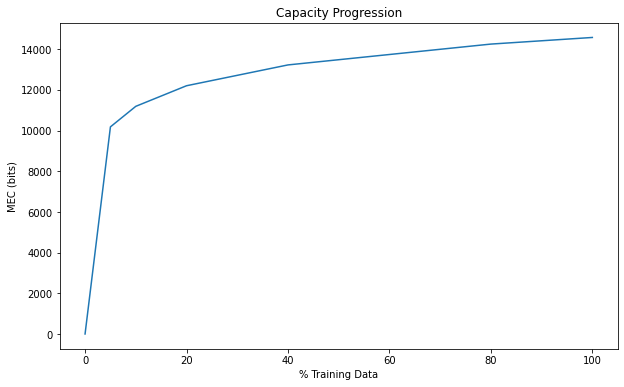

In [ ]:
capacities.update({0: 0})

lists = sorted(capacities.items()) # sorted by key, return a list of tuples

# Add title and axis names

plt.clf()
x, y = zip(*lists) # unpack a list of pairs into two tuples
# plt.ylim(0, 100)
plt.plot(x, y)
# plt.legend(loc='lower right')
plt.title('Capacity Progression')
plt.xlabel('% Training Data')
plt.ylabel('MEC (bits)')
plt.show()

# Network MEC

In [5]:
network_mec = (1024) * 256 + 256 + min(256, (256 + 1) * 10)
network_mec

262656

# Compute Generalization

In [ ]:
preds = [x.item() for x in predictions]
labs = [x.item() for x in labels]
cm = confusion_matrix(preds, labs)
cm

array([[2977,    0,    0,    2,    0,    6,    3,    0,    3,    1],
       [   0, 2991,    1,    2,    0,    0,    0,    0,    1,    0],
       [   1,    1, 2946,    0,    0,    8,    2,    0,    0,    0],
       [   0,    0,    1, 2475,    2,    0,    0,    0,   12,    0],
       [   0,    0,    0,    3, 2498,    0,    4,    7,    0,    0],
       [   6,    4,    2,    0,    0, 1980,    1,    0,    3,    0],
       [  14,    0,   46,    2,    0,    5, 2490,    0,    2,    0],
       [   0,    0,    1,    1,    0,    0,    0, 2993,    0,    0],
       [   2,    1,    1,   15,    0,    1,    0,    0, 2477,    0],
       [   0,    3,    2,    0,    0,    0,    0,    0,    2, 2999]])

In [ ]:
G = round((
    .1111 * math.log2(1/.1111) * 2977 + \
    .1111 * math.log2(1/.1111) * 2991 + \
    .1111 * math.log2(1/.1111) * 2946 + \
    .0926 * math.log2(1/.0926) * 2475 + \
    .0926 * math.log2(1/.0926) * 2498 + \
    .0741 * math.log2(1/.0741) * 1980 + \
    .0926 * math.log2(1/.0926) * 2490 + \
    .1111 * math.log2(1/.1111) * 2993 + \
    .0926 * math.log2(1/.0926) * 2477 + \
    .1111 * math.log2(1/.1111) * 2999) / 262656, 2)
G

0.03

# Compute Resilience

In [ ]:
R = round(20 * math.log10(G), 2)
R

-30.46

# Train for Memorization / Generalization

In [ ]:
network_mec = 1024 * (14) + (14) + 14
network_mec
# Add 1 for bias at every level

14364

### Train for Memorization

In [ ]:
# Reduce the neurons to get to data's capacity (14,364 bits)

model.network.fc = nn.Sequential(
                              nn.Linear(1024, 14),
                              nn.ReLU(),
                              nn.Linear(14, NUM_CLASSES),
                              nn.LogSoftmax(dim=1)
                                )

torch.cuda.empty_cache()

## Hyper Parameters
max_epochs_stop = 15
max_lr = 1e-4
grad_clip = 0.1
weight_decay = 1e-3
batch_size = 64
criterion = nn.CrossEntropyLoss()
epochs = 15
opt_func = torch.optim.Adam
## Evaluating with non-trained model
evaluate(model.cuda(), valid_dl)

## Freezing except last layer
model.freeze()
## Training
history = fit(epochs, max_lr, model, train_dl, valid_dl, weight_decay, grad_clip, opt_func, max_epochs_stop)

  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [0],train_accu: 0.8619, learning_rate: 0.0001, train_loss: 0.5817, val_loss: 0.1377, val_acc: 0.9684


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [1],train_accu: 0.9688, learning_rate: 0.0001, train_loss: 0.1222, val_loss: 0.0942, val_acc: 0.9749


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [2],train_accu: 0.9805, learning_rate: 0.0001, train_loss: 0.0747, val_loss: 0.0778, val_acc: 0.9804


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [3],train_accu: 0.9861, learning_rate: 0.0001, train_loss: 0.0517, val_loss: 0.0946, val_acc: 0.9764


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [4],train_accu: 0.9902, learning_rate: 0.0001, train_loss: 0.0380, val_loss: 0.0902, val_acc: 0.9760


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [5],train_accu: 0.9891, learning_rate: 0.0001, train_loss: 0.0403, val_loss: 0.0801, val_acc: 0.9771


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [6],train_accu: 0.9945, learning_rate: 0.0000, train_loss: 0.0234, val_loss: 0.0768, val_acc: 0.9764


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [7],train_accu: 0.9945, learning_rate: 0.0000, train_loss: 0.0237, val_loss: 0.0751, val_acc: 0.9749


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [8],train_accu: 0.9951, learning_rate: 0.0000, train_loss: 0.0219, val_loss: 0.0744, val_acc: 0.9771


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [9],train_accu: 0.9944, learning_rate: 0.0000, train_loss: 0.0241, val_loss: 0.0744, val_acc: 0.9782


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [10],train_accu: 0.9941, learning_rate: 0.0000, train_loss: 0.0257, val_loss: 0.0749, val_acc: 0.9775


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [11],train_accu: 0.9942, learning_rate: 0.0000, train_loss: 0.0248, val_loss: 0.0763, val_acc: 0.9767


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [12],train_accu: 0.9937, learning_rate: 0.0000, train_loss: 0.0263, val_loss: 0.0755, val_acc: 0.9782


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [13],train_accu: 0.9937, learning_rate: 0.0000, train_loss: 0.0263, val_loss: 0.0758, val_acc: 0.9775


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [14],train_accu: 0.9945, learning_rate: 0.0000, train_loss: 0.0241, val_loss: 0.0756, val_acc: 0.9767
VAL LOSS MIN 0.07439565658569336
VAL ACC MAX 0.9803779125213623


In [ ]:
test_ds = EuroSAT(TEST_DF, '.', data_transform)
test_dl = DataLoader(test_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)
device = get_device()
## Loading data to device
test_dl = DeviceDataLoader(test_dl, device)

predictions, labels = predict_dl(test_dl, model)
final_accuracy(predictions, labels)
preds = [x.item() for x in predictions]
labs = [x.item() for x in labels]
cm = confusion_matrix(preds, labs)
cm

True


  0%|          | 0/2700 [00:00<?, ?it/s]

0.975925925925926


array([[272,   0,   1,   0,   0,   4,   5,   0,   2,   1],
       [  1, 299,   3,   0,   0,   3,   0,   0,   0,   0],
       [  0,   0, 311,   0,   0,   3,   5,   0,   1,   0],
       [  0,   0,   0, 240,   1,   0,   0,   0,   6,   0],
       [  0,   0,   0,   0, 252,   0,   0,   0,   0,   0],
       [  1,   2,   6,   0,   0, 195,   1,   0,   2,   0],
       [  2,   0,   5,   0,   1,   0, 227,   0,   0,   0],
       [  0,   0,   1,   2,   2,   0,   0, 308,   0,   0],
       [  0,   1,   0,   0,   0,   0,   0,   0, 233,   0],
       [  0,   0,   0,   1,   0,   0,   0,   0,   2, 298]])

In [ ]:
# Reduce the neurons (12,312 bits)

model.network.fc = nn.Sequential(
                              nn.Linear(1024, 12),
                              nn.ReLU(),
                              nn.Linear(12, NUM_CLASSES),
                              nn.LogSoftmax(dim=1)
                                )

torch.cuda.empty_cache()

## Hyper Parameters
max_epochs_stop = 15
max_lr = 1e-4
grad_clip = 0.1
weight_decay = 1e-3
batch_size = 64
criterion = nn.CrossEntropyLoss()
epochs = 15
opt_func = torch.optim.Adam
## Evaluating with non-trained model
evaluate(model.cuda(), valid_dl)

## Freezing except last layer
model.freeze()
## Training
history = fit(epochs, max_lr, model, train_dl, valid_dl, weight_decay, grad_clip, opt_func, max_epochs_stop)

  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [0],train_accu: 0.9285, learning_rate: 0.0001, train_loss: 0.4073, val_loss: 0.1310, val_acc: 0.9775


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [1],train_accu: 0.9883, learning_rate: 0.0001, train_loss: 0.0710, val_loss: 0.0924, val_acc: 0.9786


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [2],train_accu: 0.9885, learning_rate: 0.0001, train_loss: 0.0539, val_loss: 0.0787, val_acc: 0.9807


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [3],train_accu: 0.9911, learning_rate: 0.0001, train_loss: 0.0390, val_loss: 0.0769, val_acc: 0.9807


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [4],train_accu: 0.9919, learning_rate: 0.0001, train_loss: 0.0368, val_loss: 0.0985, val_acc: 0.9749


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [5],train_accu: 0.9926, learning_rate: 0.0001, train_loss: 0.0308, val_loss: 0.0834, val_acc: 0.9786


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [6],train_accu: 0.9925, learning_rate: 0.0001, train_loss: 0.0320, val_loss: 0.0871, val_acc: 0.9775


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [7],train_accu: 0.9930, learning_rate: 0.0000, train_loss: 0.0292, val_loss: 0.0986, val_acc: 0.9746


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [8],train_accu: 0.9920, learning_rate: 0.0000, train_loss: 0.0308, val_loss: 0.1009, val_acc: 0.9742


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [9],train_accu: 0.9922, learning_rate: 0.0000, train_loss: 0.0322, val_loss: 0.1015, val_acc: 0.9731


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [10],train_accu: 0.9915, learning_rate: 0.0000, train_loss: 0.0315, val_loss: 0.0941, val_acc: 0.9767


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [11],train_accu: 0.9926, learning_rate: 0.0000, train_loss: 0.0307, val_loss: 0.1003, val_acc: 0.9753


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [12],train_accu: 0.9928, learning_rate: 0.0000, train_loss: 0.0308, val_loss: 0.0989, val_acc: 0.9749


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [13],train_accu: 0.9929, learning_rate: 0.0000, train_loss: 0.0293, val_loss: 0.1007, val_acc: 0.9731


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [14],train_accu: 0.9917, learning_rate: 0.0000, train_loss: 0.0327, val_loss: 0.0966, val_acc: 0.9746
VAL LOSS MIN 0.07689789682626724
VAL ACC MAX 0.9807412624359131


In [ ]:
predictions, labels = predict_dl(test_dl, model)
final_accuracy(predictions, labels)
preds = [x.item() for x in predictions]
labs = [x.item() for x in labels]
cm = confusion_matrix(preds, labs)
cm

True


  0%|          | 0/2700 [00:00<?, ?it/s]

0.9740740740740741


array([[273,   0,   0,   0,   0,   3,   8,   0,   2,   0],
       [  1, 295,   0,   0,   0,   1,   0,   0,   1,   0],
       [  0,   1, 321,   0,   0,   4,  13,   2,   0,   0],
       [  0,   0,   1, 241,   3,   0,   0,   1,  10,   0],
       [  0,   0,   0,   0, 252,   0,   0,   1,   1,   0],
       [  1,   5,   4,   0,   0, 197,   0,   0,   0,   0],
       [  1,   0,   1,   0,   1,   0, 217,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 304,   0,   0],
       [  0,   1,   0,   2,   0,   0,   0,   0, 231,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   1, 299]])

In [ ]:
# Reduce the neurons 

model.network.fc = nn.Sequential(
                              nn.Linear(1024, 11),
                              nn.ReLU(),
                              nn.Linear(11, NUM_CLASSES),
                              nn.LogSoftmax(dim=1)
                                )

torch.cuda.empty_cache()

## Hyper Parameters
max_epochs_stop = 15
max_lr = 1e-4
grad_clip = 0.1
weight_decay = 1e-3
batch_size = 64
criterion = nn.CrossEntropyLoss()
epochs = 15
opt_func = torch.optim.Adam
## Evaluating with non-trained model
evaluate(model.cuda(), valid_dl)

## Freezing except last layer
model.freeze()
## Training
history = fit(epochs, max_lr, model, train_dl, valid_dl, weight_decay, grad_clip, opt_func, max_epochs_stop)

  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [0],train_accu: 0.8977, learning_rate: 0.0001, train_loss: 0.7187, val_loss: 0.2255, val_acc: 0.9771


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [1],train_accu: 0.9916, learning_rate: 0.0001, train_loss: 0.1152, val_loss: 0.1272, val_acc: 0.9767


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [2],train_accu: 0.9907, learning_rate: 0.0001, train_loss: 0.0630, val_loss: 0.1039, val_acc: 0.9786


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [3],train_accu: 0.9932, learning_rate: 0.0001, train_loss: 0.0422, val_loss: 0.0905, val_acc: 0.9782


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [4],train_accu: 0.9926, learning_rate: 0.0001, train_loss: 0.0405, val_loss: 0.1077, val_acc: 0.9778


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [5],train_accu: 0.9936, learning_rate: 0.0001, train_loss: 0.0319, val_loss: 0.1077, val_acc: 0.9735


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [6],train_accu: 0.9935, learning_rate: 0.0001, train_loss: 0.0324, val_loss: 0.0831, val_acc: 0.9807


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [7],train_accu: 0.9961, learning_rate: 0.0001, train_loss: 0.0216, val_loss: 0.0945, val_acc: 0.9775


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [8],train_accu: 0.9941, learning_rate: 0.0001, train_loss: 0.0271, val_loss: 0.0976, val_acc: 0.9782


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [9],train_accu: 0.9922, learning_rate: 0.0001, train_loss: 0.0351, val_loss: 0.1028, val_acc: 0.9749


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [10],train_accu: 0.9967, learning_rate: 0.0000, train_loss: 0.0217, val_loss: 0.0969, val_acc: 0.9760


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [11],train_accu: 0.9961, learning_rate: 0.0000, train_loss: 0.0223, val_loss: 0.0980, val_acc: 0.9753


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [12],train_accu: 0.9961, learning_rate: 0.0000, train_loss: 0.0225, val_loss: 0.1020, val_acc: 0.9742


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [13],train_accu: 0.9956, learning_rate: 0.0000, train_loss: 0.0241, val_loss: 0.1024, val_acc: 0.9735


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [14],train_accu: 0.9960, learning_rate: 0.0000, train_loss: 0.0225, val_loss: 0.0994, val_acc: 0.9753
VAL LOSS MIN 0.08314140141010284
VAL ACC MAX 0.9807412624359131


In [ ]:
predictions, labels = predict_dl(test_dl, model)
final_accuracy(predictions, labels)
preds = [x.item() for x in predictions]
labs = [x.item() for x in labels]
cm = confusion_matrix(preds, labs)
cm

  0%|          | 0/2700 [00:00<?, ?it/s]

0.98


array([[272,   0,   0,   0,   0,   2,   2,   0,   3,   1],
       [  0, 297,   0,   0,   0,   1,   0,   0,   0,   0],
       [  0,   1, 323,   0,   0,   4,  10,   0,   0,   0],
       [  0,   0,   0, 239,   2,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 247,   0,   0,   1,   0,   0],
       [  2,   3,   2,   0,   0, 198,   1,   0,   0,   0],
       [  2,   0,   2,   0,   5,   0, 225,   0,   2,   0],
       [  0,   0,   0,   0,   2,   0,   0, 307,   0,   0],
       [  0,   1,   0,   4,   0,   0,   0,   0, 240,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   1, 298]])

In [ ]:
# # Reduce the neurons (10,250 bits)
model.network.fc = nn.Sequential(
                              nn.Linear(1024, 10),
                              nn.LogSoftmax(dim=1)
                                )
torch.cuda.empty_cache()

## Hyper Parameters
max_epochs_stop = 15
max_lr = 1e-4
grad_clip = 0.1
weight_decay = 1e-3
batch_size = 64
criterion = nn.CrossEntropyLoss()
epochs = 15
opt_func = torch.optim.Adam
## Evaluating with non-trained model
evaluate(model.cuda(), valid_dl)

## Freezing except last layer
model.freeze()
## Training
history = fit(epochs, max_lr, model, train_dl, valid_dl, weight_decay, grad_clip, opt_func, max_epochs_stop)

  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [0],train_accu: 0.9837, learning_rate: 0.0001, train_loss: 0.2345, val_loss: 0.1002, val_acc: 0.9786


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [1],train_accu: 0.9912, learning_rate: 0.0001, train_loss: 0.0497, val_loss: 0.1221, val_acc: 0.9695


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [2],train_accu: 0.9944, learning_rate: 0.0001, train_loss: 0.0300, val_loss: 0.0704, val_acc: 0.9815


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [3],train_accu: 0.9938, learning_rate: 0.0001, train_loss: 0.0294, val_loss: 0.0793, val_acc: 0.9807


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [4],train_accu: 0.9945, learning_rate: 0.0001, train_loss: 0.0257, val_loss: 0.0698, val_acc: 0.9807


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [5],train_accu: 0.9931, learning_rate: 0.0001, train_loss: 0.0307, val_loss: 0.0984, val_acc: 0.9749


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [6],train_accu: 0.9952, learning_rate: 0.0001, train_loss: 0.0218, val_loss: 0.0797, val_acc: 0.9782


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [7],train_accu: 0.9951, learning_rate: 0.0001, train_loss: 0.0213, val_loss: 0.0937, val_acc: 0.9760


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [8],train_accu: 0.9921, learning_rate: 0.0000, train_loss: 0.0308, val_loss: 0.0935, val_acc: 0.9742


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [9],train_accu: 0.9923, learning_rate: 0.0000, train_loss: 0.0310, val_loss: 0.0901, val_acc: 0.9760


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [10],train_accu: 0.9921, learning_rate: 0.0000, train_loss: 0.0320, val_loss: 0.0933, val_acc: 0.9735


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [11],train_accu: 0.9915, learning_rate: 0.0000, train_loss: 0.0314, val_loss: 0.0898, val_acc: 0.9767


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [12],train_accu: 0.9915, learning_rate: 0.0000, train_loss: 0.0329, val_loss: 0.0927, val_acc: 0.9742


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [13],train_accu: 0.9912, learning_rate: 0.0000, train_loss: 0.0332, val_loss: 0.0894, val_acc: 0.9767


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [14],train_accu: 0.9908, learning_rate: 0.0000, train_loss: 0.0336, val_loss: 0.0931, val_acc: 0.9757
VAL LOSS MIN 0.06975825875997543
VAL ACC MAX 0.9814680218696594


In [ ]:
predictions, labels = predict_dl(test_dl, model)
final_accuracy(predictions, labels)
preds = [x.item() for x in predictions]
labs = [x.item() for x in labels]
cm = confusion_matrix(preds, labs)
cm

  0%|          | 0/2700 [00:00<?, ?it/s]

0.9744444444444444


array([[270,   0,   0,   0,   0,   3,   3,   0,   2,   2],
       [  0, 283,   0,   0,   0,   0,   0,   0,   1,   0],
       [  0,   7, 321,   0,   0,   5,   4,   0,   1,   0],
       [  0,   0,   0, 242,   2,   0,   0,   0,   1,   0],
       [  0,   0,   0,   0, 246,   0,   0,   0,   0,   0],
       [  3,  12,   2,   0,   0, 197,   0,   0,   2,   2],
       [  2,   0,   3,   0,   2,   0, 231,   0,   0,   0],
       [  0,   0,   1,   0,   6,   0,   0, 308,   0,   0],
       [  1,   0,   0,   1,   0,   0,   0,   0, 238,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   1, 295]])

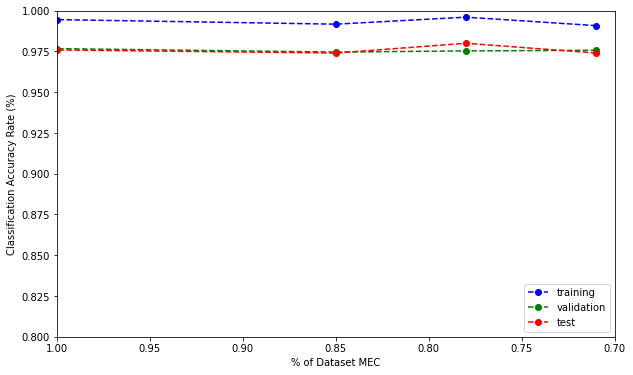

In [ ]:
import matplotlib.pyplot as plt

train_acc = {
100: 99.45, # 14364
85: 99.17, # 12312
78: 99.6, 
71: 99.08}

val_acc = {
100: 97.67,
85: 97.46, 
78: 97.53, 
71: 97.57}

test_acc = {
100: 97.59,
85: 97.40, 
78: 98, 
71: 97.4}

train_acc = sorted(train_acc.items()) # sorted by key, return a list of tuples
val_acc = sorted(val_acc.items()) # sorted by key, return a list of tuples
test_acc = sorted(test_acc.items()) # sorted by key, return a list of tuples

# Add title and axis names

# creating an x sequence
x = np.linspace(100, 70)

plt.clf()
x1, y1 = zip(*train_acc) # unpack a list of pairs into two tuples
x2, y2 = zip(*val_acc) # unpack a list of pairs into two tuples
x3, y3 = zip(*test_acc) # unpack a list of pairs into two tuples
plt.ylim(80, 100)
plt.plot(x1, y1, '--bo', label="training")
plt.plot(x2, y2, '--go', label="validation")
plt.plot(x3, y3, '--ro', label="test")
plt.legend(loc='lower right')
plt.title('')
plt.xlabel('% of Dataset MEC')
plt.ylabel('Classification Accuracy Rate (%)')
plt.rcParams["figure.figsize"] = (10,6)
plt.xlim(max(x), min(x))
plt.show()

## Create new model to reduce MEC further

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Reduce the # of neurons to 8,690 bits

class Net(MulticlassClassifierBase):

    def __init__(self):
        super(Net, self).__init__()

        # 1 input image channel, 12 output channels, square convolution
        
        conv1_in_channels=3
        conv1_out_channels=12

        conv2_in_channels=conv1_out_channels
        conv2_out_channels=24

        conv3_in_channels=conv2_out_channels
        conv3_out_channels=3

        # conv4_in_channels=conv3_out_channels
        # conv4_out_channels=32

        padding=0

        # fc_in = c * h * w
        fc1_in_features=conv3_out_channels * 17 * 17  # from image dimension at conv1 output
        fc1_out_features=10

        # fc2_in_features=fc1_out_features
        # fc2_out_features=10 # Final # classes = 2 for x, y coords

        self.conv1 = nn.Conv2d(in_channels=conv1_in_channels, out_channels=conv1_out_channels, kernel_size=13, padding=padding)
        self.conv2 = nn.Conv2d(in_channels=conv2_in_channels, out_channels=conv2_out_channels, kernel_size=13, padding=padding)
        self.conv3 = nn.Conv2d(in_channels=conv3_in_channels, out_channels=conv3_out_channels, kernel_size=13, padding=padding)
        # self.conv4 = nn.Conv2d(in_channels=conv4_in_channels, out_channels=conv4_out_channels, kernel_size=3, padding=padding)
        self.fc1 = nn.Linear(in_features=fc1_in_features, out_features=fc1_out_features) 
        # self.fc2 = nn.Linear(in_features=fc2_in_features, out_features=fc2_out_features) 

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # print(x.shape)
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        # print(x.shape)
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        # print(x.shape)
        # x = F.max_pool2d(F.relu(self.conv4(x)), (2, 2))
        # print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        # print(x.shape)
        x = nn.LogSoftmax(dim=1)((self.fc1(x)))
        # print(x.shape)
        # x = self.fc2(x)
        # print(x.shape)
        return x

model = Net()
print(model)

torch.cuda.empty_cache()

## Hyper Parameters
max_epochs_stop = 50
max_lr = 1e-4
grad_clip = 0.1
weight_decay = 1e-3
batch_size = 64
criterion = nn.CrossEntropyLoss()
epochs = 50
opt_func = torch.optim.Adam
## Evaluating with non-trained model
evaluate(model.cuda(), valid_dl)

## Training
history = fit(epochs, max_lr, model, train_dl, valid_dl, weight_decay, grad_clip, opt_func, max_epochs_stop)

Net(
  (conv1): Conv2d(3, 12, kernel_size=(13, 13), stride=(1, 1))
  (conv2): Conv2d(12, 24, kernel_size=(13, 13), stride=(1, 1))
  (conv3): Conv2d(24, 3, kernel_size=(13, 13), stride=(1, 1))
  (fc1): Linear(in_features=867, out_features=10, bias=True)
)


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [0],train_accu: 0.1389, learning_rate: 0.0001, train_loss: 2.1177, val_loss: 2.0699, val_acc: 0.1613


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [1],train_accu: 0.2269, learning_rate: 0.0001, train_loss: 2.0681, val_loss: 2.0365, val_acc: 0.2579


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [2],train_accu: 0.2569, learning_rate: 0.0001, train_loss: 2.0482, val_loss: 2.0572, val_acc: 0.2531


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [3],train_accu: 0.2635, learning_rate: 0.0001, train_loss: 2.0341, val_loss: 2.0152, val_acc: 0.2604


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [4],train_accu: 0.2668, learning_rate: 0.0001, train_loss: 2.0223, val_loss: 2.0146, val_acc: 0.2611


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [5],train_accu: 0.2679, learning_rate: 0.0001, train_loss: 2.0137, val_loss: 1.9935, val_acc: 0.2722


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [6],train_accu: 0.2735, learning_rate: 0.0001, train_loss: 1.9988, val_loss: 1.9813, val_acc: 0.2724


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [7],train_accu: 0.2752, learning_rate: 0.0001, train_loss: 1.9855, val_loss: 1.9640, val_acc: 0.2750


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [8],train_accu: 0.2757, learning_rate: 0.0001, train_loss: 1.9725, val_loss: 1.9447, val_acc: 0.2877


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [9],train_accu: 0.2766, learning_rate: 0.0001, train_loss: 1.9654, val_loss: 1.9433, val_acc: 0.2849


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [10],train_accu: 0.2808, learning_rate: 0.0001, train_loss: 1.9524, val_loss: 1.9261, val_acc: 0.2936


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [11],train_accu: 0.3002, learning_rate: 0.0001, train_loss: 1.7508, val_loss: 1.6163, val_acc: 0.3383


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [12],train_accu: 0.3391, learning_rate: 0.0001, train_loss: 1.6254, val_loss: 1.6156, val_acc: 0.3551


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [13],train_accu: 0.3693, learning_rate: 0.0001, train_loss: 1.5739, val_loss: 1.4715, val_acc: 0.4205


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [14],train_accu: 0.4197, learning_rate: 0.0001, train_loss: 1.4678, val_loss: 1.4281, val_acc: 0.4213


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [15],train_accu: 0.4311, learning_rate: 0.0001, train_loss: 1.4278, val_loss: 1.4095, val_acc: 0.4471


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [16],train_accu: 0.4401, learning_rate: 0.0001, train_loss: 1.3999, val_loss: 1.3991, val_acc: 0.4306


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [17],train_accu: 0.4359, learning_rate: 0.0001, train_loss: 1.3917, val_loss: 1.4426, val_acc: 0.4150


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [18],train_accu: 0.4518, learning_rate: 0.0001, train_loss: 1.3736, val_loss: 1.4269, val_acc: 0.4685


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [19],train_accu: 0.4669, learning_rate: 0.0001, train_loss: 1.3715, val_loss: 1.3569, val_acc: 0.4844


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [20],train_accu: 0.4790, learning_rate: 0.0001, train_loss: 1.3397, val_loss: 1.3916, val_acc: 0.4516


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [21],train_accu: 0.4831, learning_rate: 0.0001, train_loss: 1.3410, val_loss: 1.3218, val_acc: 0.4924


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [22],train_accu: 0.4945, learning_rate: 0.0001, train_loss: 1.3129, val_loss: 1.3210, val_acc: 0.4955


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [23],train_accu: 0.4982, learning_rate: 0.0001, train_loss: 1.3181, val_loss: 1.4073, val_acc: 0.4667


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [24],train_accu: 0.5037, learning_rate: 0.0001, train_loss: 1.2991, val_loss: 1.3681, val_acc: 0.4829


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [25],train_accu: 0.5065, learning_rate: 0.0001, train_loss: 1.2944, val_loss: 1.3234, val_acc: 0.4979


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [26],train_accu: 0.5237, learning_rate: 0.0000, train_loss: 1.2583, val_loss: 1.3231, val_acc: 0.4987


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [27],train_accu: 0.5242, learning_rate: 0.0000, train_loss: 1.2577, val_loss: 1.3228, val_acc: 0.4990


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [28],train_accu: 0.5240, learning_rate: 0.0000, train_loss: 1.2577, val_loss: 1.3225, val_acc: 0.4998


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [29],train_accu: 0.5243, learning_rate: 0.0000, train_loss: 1.2577, val_loss: 1.3222, val_acc: 0.4998


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [30],train_accu: 0.5248, learning_rate: 0.0000, train_loss: 1.2569, val_loss: 1.3219, val_acc: 0.5001


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [31],train_accu: 0.5248, learning_rate: 0.0000, train_loss: 1.2569, val_loss: 1.3216, val_acc: 0.4994


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [32],train_accu: 0.5250, learning_rate: 0.0000, train_loss: 1.2562, val_loss: 1.3214, val_acc: 0.4990


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [33],train_accu: 0.5255, learning_rate: 0.0000, train_loss: 1.2559, val_loss: 1.3211, val_acc: 0.4987


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [34],train_accu: 0.5256, learning_rate: 0.0000, train_loss: 1.2557, val_loss: 1.3209, val_acc: 0.4987


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [35],train_accu: 0.5254, learning_rate: 0.0000, train_loss: 1.2564, val_loss: 1.3206, val_acc: 0.4987


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [36],train_accu: 0.5256, learning_rate: 0.0000, train_loss: 1.2559, val_loss: 1.3204, val_acc: 0.4998


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [37],train_accu: 0.5257, learning_rate: 0.0000, train_loss: 1.2562, val_loss: 1.3202, val_acc: 0.5001


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [38],train_accu: 0.5262, learning_rate: 0.0000, train_loss: 1.2556, val_loss: 1.3199, val_acc: 0.5005


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [39],train_accu: 0.5266, learning_rate: 0.0000, train_loss: 1.2553, val_loss: 1.3197, val_acc: 0.5005


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [40],train_accu: 0.5267, learning_rate: 0.0000, train_loss: 1.2549, val_loss: 1.3195, val_acc: 0.5005


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [41],train_accu: 0.5266, learning_rate: 0.0000, train_loss: 1.2547, val_loss: 1.3193, val_acc: 0.5008


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [42],train_accu: 0.5266, learning_rate: 0.0000, train_loss: 1.2544, val_loss: 1.3191, val_acc: 0.5012


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [43],train_accu: 0.5268, learning_rate: 0.0000, train_loss: 1.2542, val_loss: 1.3189, val_acc: 0.5016


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [44],train_accu: 0.5268, learning_rate: 0.0000, train_loss: 1.2545, val_loss: 1.3187, val_acc: 0.5016


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [45],train_accu: 0.5270, learning_rate: 0.0000, train_loss: 1.2541, val_loss: 1.3186, val_acc: 0.5008


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [46],train_accu: 0.5276, learning_rate: 0.0000, train_loss: 1.2535, val_loss: 1.3184, val_acc: 0.5012


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [47],train_accu: 0.5281, learning_rate: 0.0000, train_loss: 1.2533, val_loss: 1.3182, val_acc: 0.5008


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [48],train_accu: 0.5279, learning_rate: 0.0000, train_loss: 1.2540, val_loss: 1.3180, val_acc: 0.5012


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [49],train_accu: 0.5283, learning_rate: 0.0000, train_loss: 1.2531, val_loss: 1.3179, val_acc: 0.5012
VAL LOSS MIN 1.3178642988204956
VAL ACC MAX 0.5015746355056763


In [ ]:
## Hyper Parameters
max_epochs_stop = 50
max_lr = 1e-4
grad_clip = 0.1
weight_decay = 1e-3
batch_size = 64
criterion = nn.CrossEntropyLoss()
epochs = 50
opt_func = torch.optim.Adam
## Evaluating with non-trained model
evaluate(model.cuda(), valid_dl)

## Training
history = fit(epochs, max_lr, model, train_dl, valid_dl, weight_decay, grad_clip, opt_func, max_epochs_stop)

  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [0],train_accu: 0.5340, learning_rate: 0.0001, train_loss: 1.2377, val_loss: 1.3930, val_acc: 0.4695


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [1],train_accu: 0.5596, learning_rate: 0.0001, train_loss: 1.1774, val_loss: 1.1985, val_acc: 0.5505


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [2],train_accu: 0.5760, learning_rate: 0.0001, train_loss: 1.1463, val_loss: 1.1470, val_acc: 0.5839


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [3],train_accu: 0.5913, learning_rate: 0.0001, train_loss: 1.1303, val_loss: 1.1293, val_acc: 0.5912


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [4],train_accu: 0.6091, learning_rate: 0.0001, train_loss: 1.0846, val_loss: 1.1145, val_acc: 0.5872


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [5],train_accu: 0.6132, learning_rate: 0.0001, train_loss: 1.0674, val_loss: 1.0984, val_acc: 0.6008


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [6],train_accu: 0.6204, learning_rate: 0.0001, train_loss: 1.0481, val_loss: 1.1086, val_acc: 0.5996


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [7],train_accu: 0.6233, learning_rate: 0.0001, train_loss: 1.0367, val_loss: 1.0575, val_acc: 0.6135


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [8],train_accu: 0.6309, learning_rate: 0.0001, train_loss: 1.0202, val_loss: 1.0786, val_acc: 0.6168


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [9],train_accu: 0.6339, learning_rate: 0.0001, train_loss: 1.0131, val_loss: 1.0527, val_acc: 0.6141


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [10],train_accu: 0.6328, learning_rate: 0.0001, train_loss: 1.0172, val_loss: 1.0779, val_acc: 0.5999


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [11],train_accu: 0.6394, learning_rate: 0.0001, train_loss: 0.9909, val_loss: 1.0646, val_acc: 0.6123


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [12],train_accu: 0.6424, learning_rate: 0.0001, train_loss: 0.9956, val_loss: 1.0514, val_acc: 0.6197


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [13],train_accu: 0.6440, learning_rate: 0.0001, train_loss: 0.9747, val_loss: 1.0361, val_acc: 0.6250


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [14],train_accu: 0.6440, learning_rate: 0.0001, train_loss: 0.9782, val_loss: 1.0924, val_acc: 0.6007


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [15],train_accu: 0.6463, learning_rate: 0.0001, train_loss: 0.9706, val_loss: 1.0315, val_acc: 0.6153


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [16],train_accu: 0.6544, learning_rate: 0.0001, train_loss: 0.9545, val_loss: 1.0089, val_acc: 0.6290


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [17],train_accu: 0.6554, learning_rate: 0.0001, train_loss: 0.9469, val_loss: 1.0041, val_acc: 0.6374


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [18],train_accu: 0.6590, learning_rate: 0.0001, train_loss: 0.9415, val_loss: 1.0898, val_acc: 0.6097


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [19],train_accu: 0.6592, learning_rate: 0.0001, train_loss: 0.9386, val_loss: 1.0647, val_acc: 0.6065


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [20],train_accu: 0.6619, learning_rate: 0.0001, train_loss: 0.9333, val_loss: 1.0453, val_acc: 0.6228


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [21],train_accu: 0.6530, learning_rate: 0.0000, train_loss: 0.9534, val_loss: 1.0447, val_acc: 0.6232


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [22],train_accu: 0.6536, learning_rate: 0.0000, train_loss: 0.9525, val_loss: 1.0440, val_acc: 0.6235


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [23],train_accu: 0.6538, learning_rate: 0.0000, train_loss: 0.9518, val_loss: 1.0434, val_acc: 0.6232


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [24],train_accu: 0.6538, learning_rate: 0.0000, train_loss: 0.9515, val_loss: 1.0428, val_acc: 0.6235


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [25],train_accu: 0.6544, learning_rate: 0.0000, train_loss: 0.9510, val_loss: 1.0422, val_acc: 0.6243


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [26],train_accu: 0.6545, learning_rate: 0.0000, train_loss: 0.9503, val_loss: 1.0416, val_acc: 0.6239


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [27],train_accu: 0.6551, learning_rate: 0.0000, train_loss: 0.9493, val_loss: 1.0410, val_acc: 0.6254


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [28],train_accu: 0.6553, learning_rate: 0.0000, train_loss: 0.9495, val_loss: 1.0404, val_acc: 0.6261


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [29],train_accu: 0.6556, learning_rate: 0.0000, train_loss: 0.9483, val_loss: 1.0399, val_acc: 0.6257


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [30],train_accu: 0.6556, learning_rate: 0.0000, train_loss: 0.9479, val_loss: 1.0393, val_acc: 0.6257


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [31],train_accu: 0.6557, learning_rate: 0.0000, train_loss: 0.9468, val_loss: 1.0388, val_acc: 0.6257


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [32],train_accu: 0.6561, learning_rate: 0.0000, train_loss: 0.9464, val_loss: 1.0383, val_acc: 0.6261


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [33],train_accu: 0.6561, learning_rate: 0.0000, train_loss: 0.9463, val_loss: 1.0377, val_acc: 0.6257


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [34],train_accu: 0.6563, learning_rate: 0.0000, train_loss: 0.9457, val_loss: 1.0372, val_acc: 0.6257


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [35],train_accu: 0.6568, learning_rate: 0.0000, train_loss: 0.9447, val_loss: 1.0367, val_acc: 0.6257


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [36],train_accu: 0.6568, learning_rate: 0.0000, train_loss: 0.9442, val_loss: 1.0362, val_acc: 0.6257


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [37],train_accu: 0.6569, learning_rate: 0.0000, train_loss: 0.9443, val_loss: 1.0357, val_acc: 0.6265


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [38],train_accu: 0.6574, learning_rate: 0.0000, train_loss: 0.9430, val_loss: 1.0352, val_acc: 0.6272


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [39],train_accu: 0.6572, learning_rate: 0.0000, train_loss: 0.9425, val_loss: 1.0347, val_acc: 0.6275


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [40],train_accu: 0.6575, learning_rate: 0.0000, train_loss: 0.9419, val_loss: 1.0342, val_acc: 0.6279


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [41],train_accu: 0.6575, learning_rate: 0.0000, train_loss: 0.9415, val_loss: 1.0337, val_acc: 0.6279


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [42],train_accu: 0.6576, learning_rate: 0.0000, train_loss: 0.9415, val_loss: 1.0332, val_acc: 0.6286


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [43],train_accu: 0.6580, learning_rate: 0.0000, train_loss: 0.9408, val_loss: 1.0327, val_acc: 0.6290


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [44],train_accu: 0.6583, learning_rate: 0.0000, train_loss: 0.9399, val_loss: 1.0323, val_acc: 0.6286


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [45],train_accu: 0.6581, learning_rate: 0.0000, train_loss: 0.9402, val_loss: 1.0318, val_acc: 0.6286


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [46],train_accu: 0.6581, learning_rate: 0.0000, train_loss: 0.9393, val_loss: 1.0313, val_acc: 0.6286


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [47],train_accu: 0.6583, learning_rate: 0.0000, train_loss: 0.9389, val_loss: 1.0309, val_acc: 0.6286


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [48],train_accu: 0.6587, learning_rate: 0.0000, train_loss: 0.9381, val_loss: 1.0304, val_acc: 0.6290


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [49],train_accu: 0.6589, learning_rate: 0.0000, train_loss: 0.9379, val_loss: 1.0300, val_acc: 0.6283
VAL LOSS MIN 1.0041284561157227
VAL ACC MAX 0.6373546719551086


In [ ]:
## Hyper Parameters
max_epochs_stop = 50
max_lr = 1e-4
grad_clip = 0.1
weight_decay = 1e-3
batch_size = 64
criterion = nn.CrossEntropyLoss()
epochs = 50
opt_func = torch.optim.Adam
## Evaluating with non-trained model
evaluate(model.cuda(), valid_dl)

## Training
history = fit(epochs, max_lr, model, train_dl, valid_dl, weight_decay, grad_clip, opt_func, max_epochs_stop)

  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [0],train_accu: 0.6635, learning_rate: 0.0001, train_loss: 0.9250, val_loss: 0.9943, val_acc: 0.6290


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [1],train_accu: 0.6635, learning_rate: 0.0001, train_loss: 0.9318, val_loss: 1.1938, val_acc: 0.5716


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [2],train_accu: 0.6677, learning_rate: 0.0001, train_loss: 0.9168, val_loss: 0.9812, val_acc: 0.6473


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [3],train_accu: 0.6715, learning_rate: 0.0001, train_loss: 0.9064, val_loss: 1.0144, val_acc: 0.6174


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [4],train_accu: 0.6757, learning_rate: 0.0001, train_loss: 0.8979, val_loss: 1.0196, val_acc: 0.6305


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [5],train_accu: 0.6735, learning_rate: 0.0001, train_loss: 0.9026, val_loss: 0.9984, val_acc: 0.6295


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [6],train_accu: 0.6781, learning_rate: 0.0000, train_loss: 0.8761, val_loss: 0.9983, val_acc: 0.6295


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [7],train_accu: 0.6778, learning_rate: 0.0000, train_loss: 0.8768, val_loss: 0.9981, val_acc: 0.6302


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [8],train_accu: 0.6783, learning_rate: 0.0000, train_loss: 0.8760, val_loss: 0.9979, val_acc: 0.6302


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [9],train_accu: 0.6786, learning_rate: 0.0000, train_loss: 0.8756, val_loss: 0.9977, val_acc: 0.6306


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [10],train_accu: 0.6785, learning_rate: 0.0000, train_loss: 0.8759, val_loss: 0.9976, val_acc: 0.6306


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [11],train_accu: 0.6790, learning_rate: 0.0000, train_loss: 0.8754, val_loss: 0.9974, val_acc: 0.6306


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [12],train_accu: 0.6791, learning_rate: 0.0000, train_loss: 0.8754, val_loss: 0.9972, val_acc: 0.6306


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [13],train_accu: 0.6793, learning_rate: 0.0000, train_loss: 0.8751, val_loss: 0.9971, val_acc: 0.6313


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [14],train_accu: 0.6797, learning_rate: 0.0000, train_loss: 0.8748, val_loss: 0.9969, val_acc: 0.6313


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [15],train_accu: 0.6795, learning_rate: 0.0000, train_loss: 0.8751, val_loss: 0.9967, val_acc: 0.6317


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [16],train_accu: 0.6796, learning_rate: 0.0000, train_loss: 0.8748, val_loss: 0.9966, val_acc: 0.6313


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [17],train_accu: 0.6800, learning_rate: 0.0000, train_loss: 0.8743, val_loss: 0.9964, val_acc: 0.6313


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [18],train_accu: 0.6801, learning_rate: 0.0000, train_loss: 0.8738, val_loss: 0.9963, val_acc: 0.6313


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [19],train_accu: 0.6800, learning_rate: 0.0000, train_loss: 0.8741, val_loss: 0.9961, val_acc: 0.6313


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [20],train_accu: 0.6798, learning_rate: 0.0000, train_loss: 0.8749, val_loss: 0.9959, val_acc: 0.6313


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [21],train_accu: 0.6799, learning_rate: 0.0000, train_loss: 0.8741, val_loss: 0.9958, val_acc: 0.6320


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [22],train_accu: 0.6799, learning_rate: 0.0000, train_loss: 0.8740, val_loss: 0.9956, val_acc: 0.6324


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [23],train_accu: 0.6798, learning_rate: 0.0000, train_loss: 0.8743, val_loss: 0.9955, val_acc: 0.6324


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [24],train_accu: 0.6801, learning_rate: 0.0000, train_loss: 0.8737, val_loss: 0.9953, val_acc: 0.6320


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [25],train_accu: 0.6802, learning_rate: 0.0000, train_loss: 0.8739, val_loss: 0.9952, val_acc: 0.6324


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [26],train_accu: 0.6804, learning_rate: 0.0000, train_loss: 0.8734, val_loss: 0.9950, val_acc: 0.6324


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [27],train_accu: 0.6804, learning_rate: 0.0000, train_loss: 0.8736, val_loss: 0.9949, val_acc: 0.6320


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [28],train_accu: 0.6805, learning_rate: 0.0000, train_loss: 0.8732, val_loss: 0.9947, val_acc: 0.6317


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [29],train_accu: 0.6806, learning_rate: 0.0000, train_loss: 0.8730, val_loss: 0.9946, val_acc: 0.6317


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [30],train_accu: 0.6807, learning_rate: 0.0000, train_loss: 0.8727, val_loss: 0.9945, val_acc: 0.6317


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [31],train_accu: 0.6808, learning_rate: 0.0000, train_loss: 0.8729, val_loss: 0.9943, val_acc: 0.6313


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [32],train_accu: 0.6810, learning_rate: 0.0000, train_loss: 0.8725, val_loss: 0.9942, val_acc: 0.6317


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [33],train_accu: 0.6810, learning_rate: 0.0000, train_loss: 0.8722, val_loss: 0.9940, val_acc: 0.6320


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [34],train_accu: 0.6811, learning_rate: 0.0000, train_loss: 0.8721, val_loss: 0.9939, val_acc: 0.6324


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [35],train_accu: 0.6810, learning_rate: 0.0000, train_loss: 0.8721, val_loss: 0.9938, val_acc: 0.6328


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [36],train_accu: 0.6812, learning_rate: 0.0000, train_loss: 0.8720, val_loss: 0.9936, val_acc: 0.6331


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [37],train_accu: 0.6813, learning_rate: 0.0000, train_loss: 0.8721, val_loss: 0.9935, val_acc: 0.6331


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [38],train_accu: 0.6814, learning_rate: 0.0000, train_loss: 0.8717, val_loss: 0.9934, val_acc: 0.6331


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [39],train_accu: 0.6816, learning_rate: 0.0000, train_loss: 0.8718, val_loss: 0.9933, val_acc: 0.6335


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [40],train_accu: 0.6816, learning_rate: 0.0000, train_loss: 0.8714, val_loss: 0.9931, val_acc: 0.6335


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [41],train_accu: 0.6813, learning_rate: 0.0000, train_loss: 0.8717, val_loss: 0.9930, val_acc: 0.6338


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [42],train_accu: 0.6815, learning_rate: 0.0000, train_loss: 0.8707, val_loss: 0.9929, val_acc: 0.6338


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [43],train_accu: 0.6812, learning_rate: 0.0000, train_loss: 0.8713, val_loss: 0.9927, val_acc: 0.6338


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [44],train_accu: 0.6816, learning_rate: 0.0000, train_loss: 0.8707, val_loss: 0.9926, val_acc: 0.6338


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [45],train_accu: 0.6815, learning_rate: 0.0000, train_loss: 0.8710, val_loss: 0.9925, val_acc: 0.6338


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [46],train_accu: 0.6817, learning_rate: 0.0000, train_loss: 0.8706, val_loss: 0.9924, val_acc: 0.6338


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [47],train_accu: 0.6819, learning_rate: 0.0000, train_loss: 0.8705, val_loss: 0.9923, val_acc: 0.6338


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [48],train_accu: 0.6819, learning_rate: 0.0000, train_loss: 0.8709, val_loss: 0.9922, val_acc: 0.6338


  0%|          | 0/338 [00:00<?, ?it/s]

Epoch [49],train_accu: 0.6819, learning_rate: 0.0000, train_loss: 0.8704, val_loss: 0.9920, val_acc: 0.6338
VAL LOSS MIN 0.9811835885047913
VAL ACC MAX 0.6472867727279663


## Calculate capacity of raw RGB data



In [ ]:
raw_data_flattened = [x.flatten() for x in TRAIN_DF.image]
raw_data_for_capacity_df = pd.DataFrame({'image_flattened': raw_data_flattened, 'label': TRAIN_DF['label']})

In [ ]:
calculate_mec(raw_data_for_capacity_df['image_flattened'], raw_data_for_capacity_df['label'])

172252.4381367806